In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 100)

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import (RandomForestRegressor, 
#                               AdaBoostRegressor, 
                              GradientBoostingRegressor, 
#                               ExtraTreesRegressor, 
                              VotingRegressor)

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import utils

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('cian_preprocessed_no_extreme.csv', low_memory=False, index_col='cid')
print(df.shape)
df.head(3)

(56105, 31)


,location_sub_locality_name,location_latitude,location_longitude,sales_agent_category,price_value,area_value,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10712873,ЦАО,55.769707,37.591117,agency,100000.0,45.0,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,Маяковская,Белорусская,Тверская,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222
12833884,ЦАО,55.739554,37.597414,agency,500000.0,150.0,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,Кропоткинская,Парк Культуры,none,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333
145766778,ЦАО,55.722162,37.613090,agency,140000.0,114.0,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,Шаболовская,none,none,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175


In [3]:
df.drop(['price_value', 'area_value'], axis=1, inplace=True)

In [4]:
from geopy.distance import geodesic
from scipy.spatial.distance import cdist

In [5]:
def calculate_distance(r, ref):
    return geodesic([r['location_latitude'], r['location_longitude']], ref).km

def get_neighbors_data(row, df=df.reset_index()):
    calc_df = df[
        (df.index < row.name) & 
        (df['location_sub_locality_name'] == row['location_sub_locality_name'])
    ].copy()
    calc_df['distance_to_neighbor'] = calc_df[['location_latitude', 'location_longitude']].parallel_apply(
        lambda x: calculate_distance(x, ref=[row['location_latitude'], row['location_longitude']]),
        axis=1
    )
    neighbors_values = calc_df[calc_df['distance_to_neighbor'] <=1][['price_per_sqm']].mean()
    return neighbors_values.values

In [6]:
if os.path.exists('extended_data.csv'):
    df = pd.read_csv('extended_data.csv')
else:
    tqdm.pandas()
    df['neighbors_mean_price_per_sqm'] = df.progress_apply(get_neighbors_data, axis=1)
    df.to_csv('extended_data.csv', index=False)

In [7]:
# df = pd.get_dummies(
#     df, 
#     columns=['location_sub_locality_name', 'sales_agent_category', 'metro_1', 'metro_2', 'metro_3'],
#     prefix=['locname', 'agent', 'm1', 'm2', 'm3'],
#     drop_first=True
# )
# df.head(3)

In [8]:
df = pd.get_dummies(
    df, 
    columns=['location_sub_locality_name', 'sales_agent_category'],
    prefix=['locname', 'agent'],
    drop_first=True
)

metros = np.unique(df[['metro_1', 'metro_2', 'metro_3']].values.ravel())
le = LabelEncoder()
le.fit(metros)
for col in ['metro_1', 'metro_2', 'metro_3']: 
    df[col] = le.transform(df[col])
df.head(3)

,location_latitude,location_longitude,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,neighbors_mean_price_per_sqm,locname_ЗАО,locname_НАО (Новомосковский),locname_САО,locname_СВАО,locname_СЗАО,locname_ЦАО,locname_ЮАО,locname_ЮВАО,locname_ЮЗАО,agent_owner
0,55.769707,37.591117,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,423,20,236,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222,[2059.39974281],0,0,0,0,0,1,0,0,0,0
1,55.739554,37.597414,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,397,171,297,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333,[2454.02936572],0,0,0,0,0,1,0,0,0,0
2,55.722162,37.613090,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,573,297,297,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175,[1577.23936035],0,0,0,0,0,1,0,0,0,0


In [9]:
bool_cols = []
for col in tqdm(df.columns):
    if df[col].nunique() == 2:
        bool_cols.append(col) 

  0%|          | 0/38 [00:00<?, ?it/s]

# Обработка текстовых данных

In [10]:
if os.path.exists('cian_preprocessed_text_extended.csv'):
    df = pd.read_csv('cian_preprocessed_text_extended.csv').fillna('')
else:
    df['description_prep'] = df['description'].parallel_apply(
        lambda x: utils.normalize_text(
            utils.remove_stopwords(stopwords=[], text=\
                utils.clean_text(
                    utils.strip_special_characters(x)
                )
            )
        )
    )
    df.to_csv('cian_preprocessed_text_extended.csv')

In [13]:
df[['description', 'description_prep']]

,description,description_prep
0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",id 105 сдаваться от 1 мес отчётный документ ре...
1,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,агент бонус 50 50 жк опера хаус в аренда предл...
2,"ЖК Созвездие капитал-1, Предлагается в аренду ...",жк созвездие капитал 1 предлагаться в аренда п...
3,АГЕНТУ БОНУС 50 000 руб! 2х-комнатные апартаме...,агент бонус 50 000 руб 2х комнатный апартамент...
4,Предлагается современная квартира в элитном ЖК...,предлагаться современный квартира в элитный жк...
...,...,...
56100,Сдаётся однокомнатная квартира в новом жилом к...,сдаваться однокомнатный квартира в новый жилой...
56101,"Сдам 1-комнатную квартиру. светлая, уютная, ок...",сдать 1 комнатный квартира светлый уютный окно...
56102,Сдаётся полностью мебелированная 2-х комнатная...,сдаваться полностью мебелировать 2 х комнатный...
56103,ПИК-Аренда простой и безопасный способ снять ...,пик аренда простой и безопасный способ снять к...


In [22]:
pd.read_csv('extended_data.csv')

,location_sub_locality_name,location_latitude,location_longitude,sales_agent_category,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,neighbors_mean_price_per_sqm
0,ЦАО,55.769707,37.591117,agency,27.000000,8.000000,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,Маяковская,Белорусская,Тверская,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222,[2059.39974281]
1,ЦАО,55.739554,37.597414,agency,100.000000,50.000000,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,Кропоткинская,Парк Культуры,none,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333,[2454.02936572]
2,ЦАО,55.722162,37.613090,agency,64.000000,20.000000,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,Шаболовская,none,none,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175,[1577.23936035]
3,ЦАО,55.758453,37.625055,agency,70.000000,12.835821,АГЕНТУ БОНУС 50 000 руб! 2х-комнатные апартаме...,0,4.0,5.0,0,0,Лубянка,none,none,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,2.0,-1.0,999.0,5.0,0.813953,0.149254,5116.279070,[2399.04378891]
4,ЦАО,55.736523,37.617150,agency,62.222222,15.000000,Предлагается современная квартира в элитном ЖК...,0,7.0,11.0,0,0,Полянка,none,none,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,-1.0,999.0,11.0,0.622222,0.150000,3000.000000,[2258.90419612]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56100,НАО (Новомосковский),55.633887,37.412307,agency,20.800000,9.302326,Сдаётся однокомнатная квартира в новом жилом к...,0,5.0,16.0,60,0,Саларьево,Румянцево,Солнцево,-1.0,-1.0,-1.0,4.0,6.0,7.0,-1.0,999.0,7.0,4.0,24.0,0.520000,0.232558,1075.000000,[1083.0342098]
56101,НАО (Новомосковский),55.636870,37.323455,owner,20.000000,7.500000,"Сдам 1-комнатную квартиру. светлая, уютная, ок...",0,14.0,17.0,0,0,Рассказовка,Новопеределкино,none,7.0,-1.0,-1.0,3.0,-1.0,-1.0,7.0,7.0,3.0,3.0,17.0,0.526316,0.197368,973.684211,[963.17605223]
56102,НАО (Новомосковский),55.515543,37.373931,owner,31.200000,15.000000,Сдаётся полностью мебелированная 2-х комнатная...,0,2.0,3.0,0,0,Ольховая,Теплый Стан,none,-1.0,-1.0,-1.0,10.0,15.0,-1.0,-1.0,999.0,15.0,10.0,3.0,0.520000,0.250000,783.333333,[696.30913034]
56103,НАО (Новомосковский),55.602373,37.376608,agency,26.300000,13.000000,ПИК-Аренда простой и безопасный способ снять ...,0,3.0,25.0,50,0,Филатов Луг,none,none,-1.0,-1.0,-1.0,15.0,-1.0,-1.0,-1.0,999.0,15.0,15.0,27.0,0.451115,0.222985,1200.686106,[868.28638003]


In [21]:
df

,location_latitude,location_longitude,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,neighbors_mean_price_per_sqm,locname_ЗАО,locname_НАО (Новомосковский),locname_САО,locname_СВАО,locname_СЗАО,locname_ЦАО,locname_ЮАО,locname_ЮВАО,locname_ЮЗАО,agent_owner
0,55.769707,37.591117,27.000000,8.000000,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,423,20,236,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222,[2059.39974281],0,0,0,0,0,1,0,0,0,0
1,55.739554,37.597414,100.000000,50.000000,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,397,171,297,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333,[2454.02936572],0,0,0,0,0,1,0,0,0,0
2,55.722162,37.613090,64.000000,20.000000,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,573,297,297,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175,[1577.23936035],0,0,0,0,0,1,0,0,0,0
3,55.758453,37.625055,70.000000,12.835821,АГЕНТУ БОНУС 50 000 руб! 2х-комнатные апартаме...,0,4.0,5.0,0,0,415,297,297,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,2.0,-1.0,999.0,5.0,0.813953,0.149254,5116.279070,[2399.04378891],0,0,0,0,0,1,0,0,0,0
4,55.736523,37.617150,62.222222,15.000000,Предлагается современная квартира в элитном ЖК...,0,7.0,11.0,0,0,484,297,297,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,-1.0,999.0,11.0,0.622222,0.150000,3000.000000,[2258.90419612],0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56100,55.633887,37.412307,20.800000,9.302326,Сдаётся однокомнатная квартира в новом жилом к...,0,5.0,16.0,60,0,505,208,225,-1.0,-1.0,-1.0,4.0,6.0,7.0,-1.0,999.0,7.0,4.0,24.0,0.520000,0.232558,1075.000000,[1083.0342098],0,1,0,0,0,0,0,0,0,0
56101,55.636870,37.323455,20.000000,7.500000,"Сдам 1-комнатную квартиру. светлая, уютная, ок...",0,14.0,17.0,0,0,496,152,297,7.0,-1.0,-1.0,3.0,-1.0,-1.0,7.0,7.0,3.0,3.0,17.0,0.526316,0.197368,973.684211,[963.17605223],0,1,0,0,0,0,0,0,0,1
56102,55.515543,37.373931,31.200000,15.000000,Сдаётся полностью мебелированная 2-х комнатная...,0,2.0,3.0,0,0,458,241,297,-1.0,-1.0,-1.0,10.0,15.0,-1.0,-1.0,999.0,15.0,10.0,3.0,0.520000,0.250000,783.333333,[696.30913034],0,1,0,0,0,0,0,0,0,1
56103,55.602373,37.376608,26.300000,13.000000,ПИК-Аренда простой и безопасный способ снять ...,0,3.0,25.0,50,0,557,297,297,-1.0,-1.0,-1.0,15.0,-1.0,-1.0,-1.0,999.0,15.0,15.0,27.0,0.451115,0.222985,1200.686106,[868.28638003],0,1,0,0,0,0,0,0,0,0


In [19]:
df['neighbors_mean_price_per_sqm'] = df[
    'neighbors_mean_price_per_sqm'].map(lambda x: x.replace('[', '').replace(']', '')).astype(np.float64)

In [14]:
# tmp = df[['cid', 'description', 'location_longitude', 'location_latitude', 'description_prep']].copy()
# tmp
# df.reset_index().merge(tmp, on=['description', 'location_longitude', 'location_latitude'], how='inner')
# df.reset_index().merge(tmp, on='cid', how='inner').to_csv('cian_preprocessed_text_2.csv')

# Разбиение датасета

In [20]:
target = 'price_per_sqm'
text_cols = ['description', 'description_prep']
num_cols = [i for i in df.columns if i not in bool_cols + text_cols + [target]]
feature_cols = text_cols + bool_cols + num_cols

In [21]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
    df[feature_cols], 
    df[target], 
    test_size=0.15, 
    random_state=17
)

In [22]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full, 
    test_size=0.15, 
    random_state=17
)

In [23]:
x_train_full.shape, x_train.shape, x_valid.shape, x_test.shape, \
y_train_full.shape, y_train.shape, y_valid.shape, y_test.shape

((47689, 38),
 (40535, 38),
 (7154, 38),
 (8416, 38),
 (47689,),
 (40535,),
 (7154,),
 (8416,))

# Проверка аплифта от добавления текстовых данных

In [24]:
# max_features = [100, 300, 1000, 30000]
# train_scores = {i: [] for i in max_features}
# val_scores = {i: [] for i in max_features}

# kf = KFold(n_splits=5, shuffle=True, random_state=17)

# for n in max_features:
#     print(f'\nmax features {n}')
#     for fold, (train_index, test_index) in enumerate(kf.split(x_train)):
#         x_train_fold, y_train_fold = x_train.iloc[train_index], y_train.iloc[train_index]
#         x_test_fold, y_test_fold = x_train.iloc[test_index], y_train.iloc[test_index]
        
#         tfidf = TfidfVectorizer(max_features=n)
#         x_train_text_encoded = tfidf.fit_transform(x_train_fold['description_prep'])
#         x_test_text_encoded = tfidf.transform(x_test_fold['description_prep'])
        
#         x_train_fold = pd.concat([
#             x_train_fold, 
#             pd.DataFrame(x_train_text_encoded.toarray(), 
#                          columns=tfidf.get_feature_names_out(), 
#                          index=x_train_fold.index)
#         ], axis=1)

#         x_test_fold = pd.concat([
#             x_test_fold, 
#             pd.DataFrame(x_test_text_encoded.toarray(), 
#                          columns=tfidf.get_feature_names_out(), 
#                          index=x_test_fold.index)
#         ], axis=1)
        
#         cbs = CatBoostRegressor()
#         cbs.fit(
#             x_train_fold.drop(text_cols, axis=1), 
#             y_train_fold, 
#             eval_set=(x_test_fold.drop(text_cols, axis=1), y_test_fold),
#             verbose=0,
#             plot=False
#         )
        
#         mape_val = mean_absolute_percentage_error(cbs.get_test_eval(), y_test_fold)
#         mape_train = mean_absolute_percentage_error(
#             cbs.predict(x_train_fold.drop(text_cols, axis=1)), y_train_fold)
        
#         train_scores[n].append(mape_train)
#         val_scores[n].append(mape_val)
#         print(f"""fold {fold}:
#         train_score = {100*train_scores[n][-1]:.2f}%
#         test_score = {100*val_scores[n][-1]:.2f}%""")
        
# for key_train, key_val in zip(list(train_scores.keys())[:3], list(val_scores.keys())[:3]):
#     print(f'n_features {key_train} mean train mape {100*np.mean(train_scores[key_train]):.2f}%')
#     print(f'n_features {key_val} mean train mape {100*np.mean(val_scores[key_val]):.2f}%\n')

In [25]:
tfidf = TfidfVectorizer(max_features=300)
x_train_text_encoded = tfidf.fit_transform(x_train['description_prep'])
x_valid_text_encoded = tfidf.transform(x_valid['description_prep'])

In [26]:
x_train = pd.concat([
    x_train, 
    pd.DataFrame(x_train_text_encoded.toarray(), 
                 columns=tfidf.get_feature_names_out(), 
                 index=x_train.index)
], axis=1)

In [27]:
x_valid = pd.concat([
    x_valid, 
    pd.DataFrame(x_valid_text_encoded.toarray(), 
                 columns=tfidf.get_feature_names_out(), 
                 index=x_valid.index)
], axis=1)

In [28]:
cbs = CatBoostRegressor()

In [29]:
cbs.fit(
    x_train.drop(text_cols, axis=1), 
    y_train, 
    eval_set=(x_valid.drop(text_cols, axis=1), y_valid),
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091059
0:	learn: 610.2525971	test: 626.7957031	best: 626.7957031 (0)	total: 92.2ms	remaining: 1m 32s
50:	learn: 329.8039790	test: 351.9231654	best: 351.9231654 (50)	total: 1.47s	remaining: 27.4s
100:	learn: 308.4445731	test: 337.1565936	best: 337.1565936 (100)	total: 2.72s	remaining: 24.3s
150:	learn: 292.1598489	test: 326.4323732	best: 326.4323732 (150)	total: 3.98s	remaining: 22.4s
200:	learn: 279.1978311	test: 318.7743874	best: 318.7743874 (200)	total: 5.27s	remaining: 20.9s
250:	learn: 269.7045561	test: 314.5343387	best: 314.5208989 (249)	total: 6.62s	remaining: 19.8s
300:	learn: 261.4222989	test: 311.5358088	best: 311.5358088 (300)	total: 7.88s	remaining: 18.3s
350:	learn: 254.0068702	test: 308.8196571	best: 308.8196571 (350)	total: 9.2s	remaining: 17s
400:	learn: 247.9445882	test: 307.0030740	best: 307.0030740 (400)	total: 10.4s	remaining: 15.6s
450:	learn: 242.5583540	test: 305.4700885	best: 305.4700885 (450)	total: 11.7s	remaining: 14.3s
500:	learn: 237.4

In [30]:
mse_val = mean_squared_error(cbs.get_test_eval(), y_valid, squared=False)
mape_val = mean_absolute_percentage_error(cbs.get_test_eval(), y_valid)

In [31]:
print(f"""mse_val: {mse_val:.4f}
mape_val: {mape_val*100:.2f}%""")

mse_val: 294.8662
mape_val: 12.87%


In [32]:
cbs.score(x_valid.drop(text_cols, axis=1), y_valid)

0.8011406327460783

In [ ]:
x_train

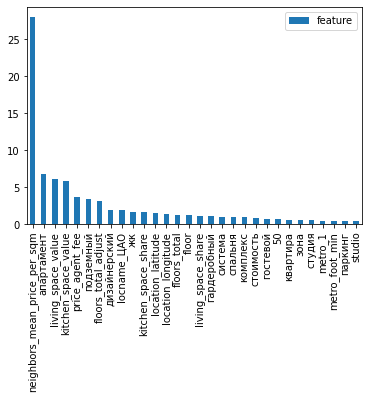

In [34]:
imp = pd.DataFrame(cbs.feature_importances_, cbs.feature_names_, columns=['feature']
                  ).sort_values('feature', ascending=False).head(30)
imp.plot(kind='bar');

In [35]:
pd.DataFrame(cbs.feature_importances_, cbs.feature_names_).sort_values(0, ascending=False).head(30)

,0
neighbors_mean_price_per_sqm,27.989828
апартамент,6.739473
living_space_value,6.155773
kitchen_space_value,5.839975
price_agent_fee,3.681357
подземный,3.368222
floors_total_adjust,3.125598
дизайнерский,1.976362
locname_ЦАО,1.918383
жк,1.676857


In [36]:
import shap

explainer = shap.TreeExplainer(cbs)
shap_values = explainer.shap_values(x_train.drop(text_cols, axis=1))

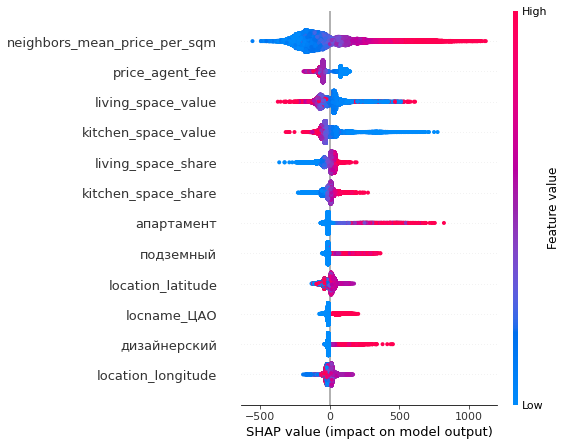

In [156]:
shap.summary_plot(shap_values, x_train.drop(text_cols, axis=1), max_display=12)

In [171]:
df.loc[x_train.iloc[123:124].index][['price_per_sqm']+df.columns.tolist()]

,price_per_sqm,location_latitude,location_longitude,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,neighbors_mean_price_per_sqm,locname_ЗАО,locname_НАО (Новомосковский),locname_САО,locname_СВАО,locname_СЗАО,locname_ЦАО,locname_ЮАО,locname_ЮВАО,locname_ЮЗАО,agent_owner,description_prep
49882,900.0,55.572365,37.591458,20.0,9.0,Замечательная квартира с качественным ремонто...,0,5.0,14.0,100,0,332,262,25,12.0,12.0,-1.0,3.0,-1.0,-1.0,12.0,12.0,3.0,3.0,14.0,0.5,0.225,900.0,840.524357,0,0,0,0,0,0,0,0,1,0,замечательный квартира с качественный ремонт п...


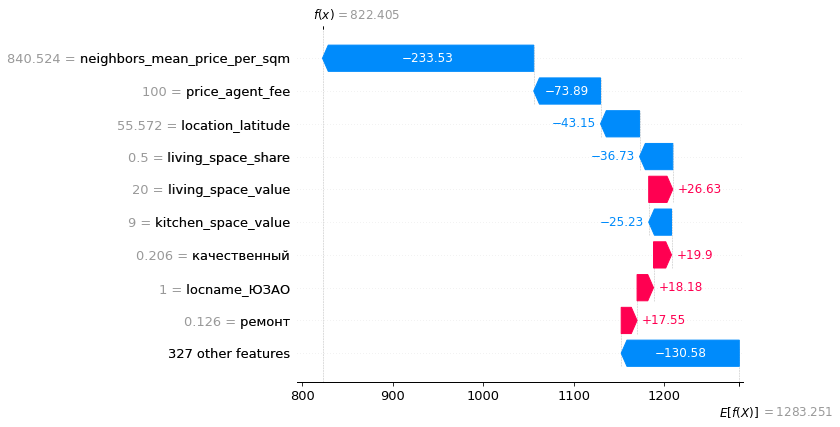

In [47]:
shap.plots.waterfall(explainer(x_train.drop(text_cols, axis=1))[123])

In [74]:
df.loc[x_valid.iloc[124:125].index][['price_per_sqm']+df.columns.tolist()]

,price_per_sqm,location_latitude,location_longitude,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,neighbors_mean_price_per_sqm,locname_ЗАО,locname_НАО (Новомосковский),locname_САО,locname_СВАО,locname_СЗАО,locname_ЦАО,locname_ЮАО,locname_ЮВАО,locname_ЮЗАО,agent_owner,description_prep
44155,1235.955056,55.786809,37.612856,30.0,7.0,"Квартира в хорошем состоянии, ремонт и мебель...",0,5.0,9.0,50,0,364,124,129,9.0,10.0,17.0,-1.0,-1.0,-1.0,17.0,9.0,-1.0,999.0,9.0,0.674157,0.157303,1235.955056,1273.420077,0,0,0,1,0,0,0,0,0,1,квартира в хороший состояние ремонт и мебель с...


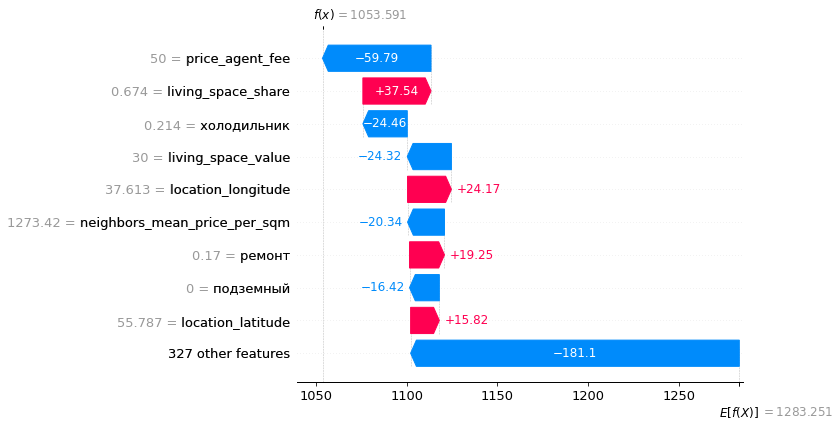

In [73]:
shap.plots.waterfall(explainer(x_valid.drop(text_cols, axis=1))[124])

In [70]:
df.loc[x_valid.iloc[124:125].index][['price_per_sqm']+df.columns.tolist()]['description']

array(['Квартира в хорошем состоянии,  ремонт и мебель свежие.Стиральная машинка, холодильник, мебель на кухне, мебель в комнатах.Сдается на длительный срок,  от года.'],
      dtype=object)

In [118]:
df_explore = df.copy()
df_explore['is_appartment'] = df_explore['description_prep'].map(lambda x: 'апартамент' in x).astype(np.uint8)
# df_explore = pd.concat([df_explore, y_train], axis=1)
df_explore.head(3)

,location_latitude,location_longitude,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,neighbors_mean_price_per_sqm,locname_ЗАО,locname_НАО (Новомосковский),locname_САО,locname_СВАО,locname_СЗАО,locname_ЦАО,locname_ЮАО,locname_ЮВАО,locname_ЮЗАО,agent_owner,description_prep,is_appartment
0,55.769707,37.591117,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,423,20,236,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222,2059.399743,0,0,0,0,0,1,0,0,0,0,id 105 сдаваться от 1 мес отчётный документ ре...,0
1,55.739554,37.597414,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,397,171,297,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333,2454.029366,0,0,0,0,0,1,0,0,0,0,агент бонус 50 50 жк опера хаус в аренда предл...,0
2,55.722162,37.613090,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,573,297,297,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175,1577.239360,0,0,0,0,0,1,0,0,0,0,жк созвездие капитал 1 предлагаться в аренда п...,0


<AxesSubplot:xlabel='is_appartment', ylabel='price_per_sqm'>

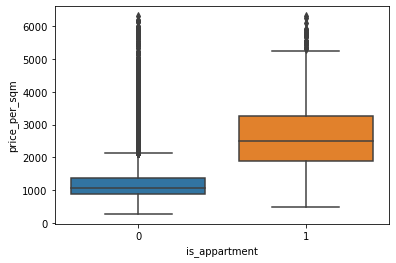

In [119]:
sns.boxplot(data=df_explore, x='is_appartment', y='price_per_sqm')

In [121]:
df_explore['closest_metro'] = le.inverse_transform(df_explore['metro_1'])

<AxesSubplot:xlabel='closest_metro', ylabel='is_appartment'>

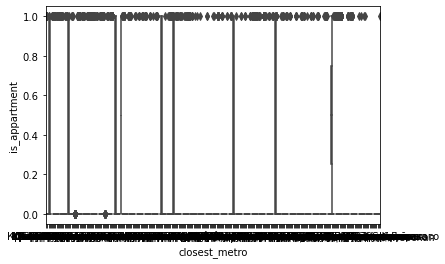

In [122]:
sns.boxplot(data=df_explore, x='closest_metro', y='is_appartment')

In [138]:
df_explore_agg = df_explore.groupby('closest_metro', as_index=False).agg({'is_appartment': ['mean', 'sum']})
df_explore_agg.columns = ['closest_metro', 'apps_share', 'apps_count']
df_explore_agg = df_explore_agg[df_explore_agg['apps_count'] > 10]
df_explore_agg.sort_values('apps_count', ascending=False)

,closest_metro,apps_share,apps_count
60,Деловой центр,0.881890,560
238,Тестовская,0.588710,146
268,ЦСКА,0.295515,112
53,Выставочная,0.324111,82
128,Международная,0.824742,80
170,Парк Победы,0.307317,63
62,Динамо,0.165242,58
22,Белорусская,0.098182,54
70,ЗИЛ,0.319277,53
32,Ботанический сад,0.163987,51


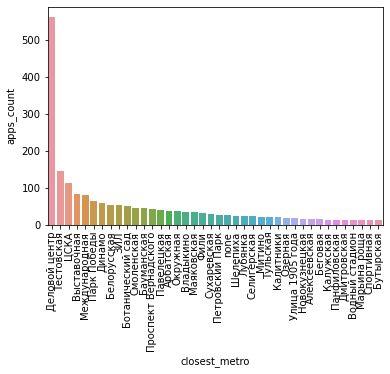

In [143]:
sns.barplot(data=df_explore_agg.sort_values('apps_count', ascending=False), 
            x='closest_metro', y='apps_count')
plt.xticks(rotation=90)
plt.show()

In [147]:
df_explore_agg_2 = df_explore.groupby('closest_metro', as_index=False).agg({'price_per_sqm': 'mean'})
df_explore_agg_2.sort_values('price_per_sqm', ascending=False).head(25)

,closest_metro,price_per_sqm
183,Площадь Революции,4052.305665
118,Лубянка,3404.953898
128,Международная,3268.725380
60,Деловой центр,3110.987666
238,Тестовская,2913.787670
233,Театральная,2908.705905
169,Парк Культуры,2566.247730
53,Выставочная,2521.627512
26,Библиотека им. Ленина,2515.309698
104,Кузнецкий мост,2478.452603


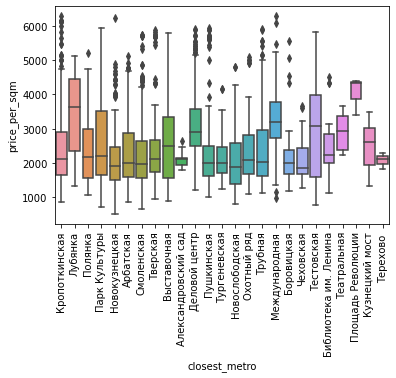

In [157]:
sns.boxplot(data=df_explore[df_explore['closest_metro'].isin(
    df_explore_agg_2.sort_values('price_per_sqm', ascending=False).head(25).closest_metro)], 
            x='closest_metro', y='price_per_sqm')
plt.xticks(rotation=90)
plt.show()

In [159]:
for _, row in df[df['description_prep'].map(lambda x: 'подземный' in x)].sample(5).iterrows():
    print(row['description']+'\n')

Лот 68517. Предлагается квартира в новом элитном доме с подземным паркингом и охраняемой территорией. Ремонт выполнен в классическом стиле. Большая кухня со вкусом обставлена мебелью и полностью оснащена встроенной бытовой техникой. Санузлы оборудованы качественной европейской сантехникой.

Предлагается в долгосрочную аренду уютная квартира с одной спальней в ЖК "Английский квартал".  Все окна выходят во двор комплекса, что позволяет наслаждаться тишиной с открытыми окнами.Квартира оборудована всем необходимым для комфортного проживания.Планировка квартиры: кухня-гостиная, спальня с гардеробными комнатами, лоджией и своим санузлом, просторная прихожая с гардеробной комнатой и гостевым санузлом.Преимущества комплекса: огороженный двор без машин, профессиональная служба охраны, подземный паркинг. В каждом подъезде консьерж-охранник. Квартира подключена к единой системе кондиционирования и вентиляции. На территории комплекса расположен детский сад, салон красоты, химчистка, аптека и миним

In [167]:
x_test_text_encoded = tfidf.transform(x_test['description_prep'])
x_test = pd.concat([
    x_test, 
    pd.DataFrame(x_test_text_encoded.toarray(), 
                 columns=tfidf.get_feature_names_out(), 
                 index=x_test.index)
], axis=1)

In [164]:
y_test_pred = cbs.predict(x_test.drop(text_cols, axis=1))

In [165]:
mse_test = mean_squared_error(y_test_pred, y_test, squared=False)
mape_test = mean_absolute_percentage_error(y_test_pred, y_test)
r2_test = cbs.score(x_test.drop(text_cols, axis=1), y_test)

In [172]:
print(f"""mse_test: {mse_test:.4f}
mape_test: {mape_test*100:.2f}%
r2_test: {r2_test:.4f}""")

mse_test: 283.4637
mape_test: 12.81%
r2_test: 0.7888


In [173]:
for i, tr, val in zip([100, 300, 1000], [12.13, 11.57, 11.52], [14.19, 13.67, 13.65]):
    print(f'n_features {i} mean train MAPE {tr}%')
    print(f'n_features {i} mean validation MAPE {val}%\n')

n_features 100 mean train MAPE 12.13%
n_features 100 mean validation MAPE 14.19%

n_features 300 mean train MAPE 11.57%
n_features 300 mean validation MAPE 13.67%

n_features 1000 mean train MAPE 11.52%
n_features 1000 mean validation MAPE 13.65%

